In [25]:
import os
import warnings

import librosa
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

warnings.filterwarnings("ignore")
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dense
from tqdm import tqdm
from keras.preprocessing.sequence import pad_sequences

In [10]:
os.chdir('/home/abstractmonkey/competitions/rfcx-species-audio-detection')
df = pd.read_csv('train_tp.csv')
df.head()

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max
0,003bec244,14,1,44.5440,2531.250,45.1307,5531.25
1,006ab765f,23,1,39.9615,7235.160,46.0452,11283.40
2,007f87ba2,12,1,39.1360,562.500,42.2720,3281.25
3,0099c367b,17,4,51.4206,1464.260,55.1996,4565.04
4,009b760e6,10,1,50.0854,947.461,52.5293,10852.70


Use the [librosa](https://librosa.org/doc/latest/index.html) package to load and display an audio file like this:

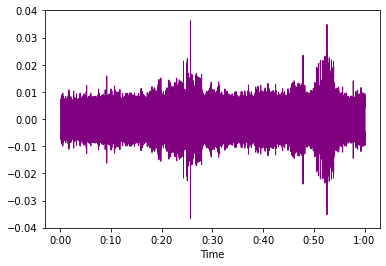

In [11]:
sample_num = 3  # Pick a file to display
filename = df.recording_id[sample_num] + str(".flac")  # Get the filename

# Define the beginning time of the signal
tstart = df.t_min[sample_num]
# Define the end time of the signal
tend = df.t_max[sample_num]
y, sr = librosa.load("train/" + str(filename))
librosa.display.waveshow(y, sr=sr, x_axis="time", color="purple", offset=0.0)

##### **Features for modeling**
[Librosa](https://conference.scipy.org/proceedings/scipy2015/pdfs/brian_mcfee.pdf) has great tutorials on how to extract features [here](https://librosa.org/doc/latest/tutorial.html). For RNNs, I found that the best feature were the Mel-frequency cepstral coefficients ([MFCCs](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum)), a spectral feature of sound.

You can calculate it like this:

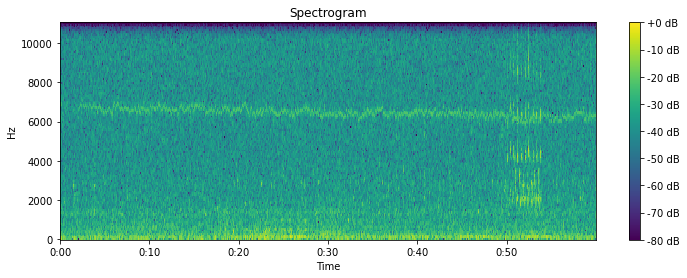

In [12]:
hop_length = 512  # The default spacing between frames
n_fft = 255  # Number of samples

# Plot the spectrogram
plt.figure(figsize=(12, 4))
D = librosa.amplitude_to_db(
    np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length)), ref=np.max
)
librosa.display.specshow(
    D, y_axis="linear", sr=sr, hop_length=hop_length, x_axis="time", cmap="viridis"
)
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram")
plt.show()

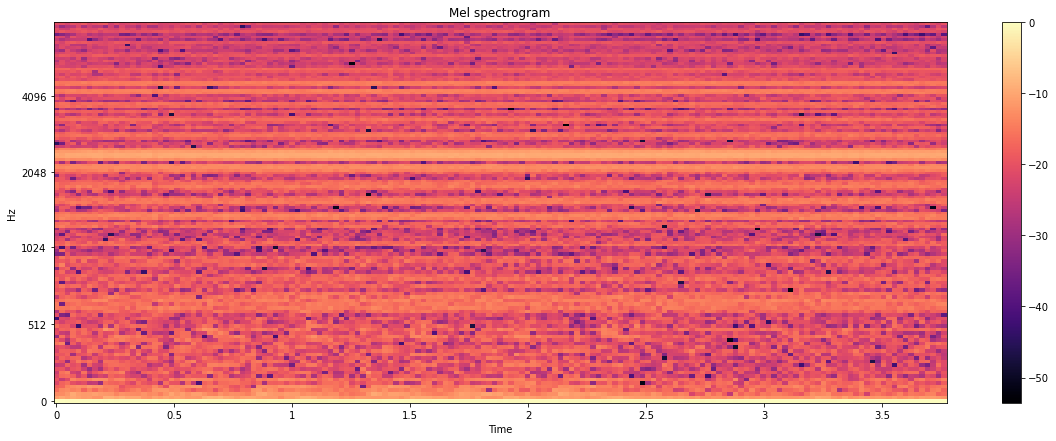

In [13]:
# My stuff...

hop_length = 512  # The default spacing between frames
n_fft = 255  # Number of samples

y_cut = y[int(round(tstart * sr)) : int(round(tend * sr))]
mfccs = librosa.feature.mfcc(
    y=y_cut, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mfcc=128
)

fig, ax = plt.subplots(figsize=(20, 7))
img = librosa.display.specshow(
    librosa.power_to_db(abs(mfccs), ref=np.max),
    x_axis="time",
    y_axis="mel",
    fmax=8000,
    ax=ax,
    hop_length=hop_length,
    n_fft=n_fft,
)
fig.colorbar(img, ax=ax)
ax.set(title="Mel spectrogram")
ax.label_outer()

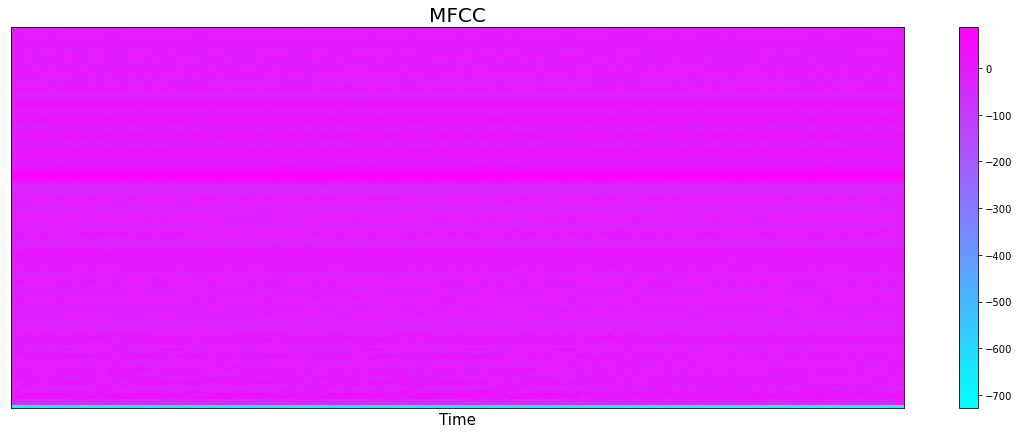

In [14]:
hop_length = 512  # The default spacing between frames
n_fft = 255  # Number of samples

# Cut the sample to the relevant times
y_cut = y[int(round(tstart * sr)) : int(round(tend * sr))]
MFCCs = librosa.feature.mfcc(y_cut, n_fft=n_fft, hop_length=hop_length, n_mfcc=128)
fig, ax = plt.subplots(figsize=(20, 7))
librosa.display.specshow(MFCCs, sr=sr, cmap="cool", hop_length=hop_length)
ax.set_xlabel("Time", fontsize=15)
ax.set_title("MFCC", size=20)
plt.colorbar()
plt.show()

##### **Extract features & labels for all the files and store in a numpy array:**

In [15]:
print("The dataset has " + str(len(df)) + " audio samples to iterate over")

The dataset has 1216 audio samples to iterate over


In [85]:
df2 = df.head(50)

f = open('/home/abstractmonkey/git/beastbox/test.txt', 'w')

def get_features(df_in):
    features = []  # List to save features
    labels = []  # List to save labels
    for index in tqdm(range(0, len(df_in))):
        # Get the filename
        filename = df_in.iloc[index]["recording_id"] + str(".flac")
        # Cut to start of signal
        tstart = df_in.iloc[index]["t_min"]
        # Cut to end of signal
        tend = df_in.iloc[index]["t_max"]
        # Save labels
        species_id = df_in.iloc[index]["species_id"]
        # Load the file
        y, sr = librosa.load("train/" + filename, sr=28000)
        f.write(str(y.shape) + "\n")
        f.write(str(len(y)) + "\n")
        # Cut the file from tstart to tend
        y_cut = y[round(tstart * sr, ndigits=None) : round(tend * sr, ndigits=None)]
        f.write(str(y_cut.shape) + "\n")
        f.write(str(len(y_cut)) + "\n")
        data = np.array(
            [
                (
                    librosa.feature.mfcc(
                        y_cut, n_fft=n_fft, hop_length=hop_length, n_mfcc=128
                    )
                )
            ]
        )
        f.write(str(data.shape) + "\n")
        f.write(str(len(data)) + "\n")
        data = pad_sequences(data, value=0, maxlen=333, padding="post", dtype="float32")
        f.write(str("Padded data") + "\n")
        f.write(str(data.shape) + "\n")
        f.write(str(len(data)) + "\n")
        f.write(str("species_id") + "\n")
        f.write(str(species_id.shape) + "\n")
        #data = np.pad(data, pad_width=(1, 400))
        features.append(data)
        labels.append(species_id)
    #output = np.concatenate(features, axis=0)
    f.close()
    #return (np.array(output), labels)
    return labels
#X, y = get_features(df2)
X = get_features(df2)

 14%|█▍        | 7/50 [00:11<01:10,  1.65s/it]

In [ ]:
features = []  # List to save features
labels = []  # List to save labels
# Get the filename
filename = df.iloc[2]["recording_id"] + str(".flac")
print("Filename: " + str(filename))
# Cut to start of signal
tstart = df.iloc[2]["t_min"]
print("tstart: " + str(tstart))
print("tstart shape: ")
print(tstart.shape)
# Cut to end of signal
tend = df.iloc[2]["t_max"]
print("tend: " + str(tend))
print("tend shape: ")
print(tend.shape)
# Save labels
species_id = df.iloc[2]["species_id"]
print("species_id: " + str(species_id))
print("species_id shape: ")
print(species_id.shape)
# Load the file
y, sr = librosa.load("train/" + filename, sr=28000)
print("y: " + str(y))
print("y shape: ")
print(y.shape)
print("sr: " + str(sr))
# Cut the file from tstart to tend
y_cut = y[round(tstart * sr, ndigits=None) : round(tend * sr, ndigits=None)]
print("y_cut: " + str(y_cut))
print("y_cut shape: ")
print(y_cut.shape)
data = np.array(
	[
		(
			librosa.feature.mfcc(
				y_cut, n_fft=n_fft, hop_length=hop_length, n_mfcc=128
			)
		)
	]
)
#print("data pre-pad: " + str(data))
print("data pre-pad shape: ")
print(data.shape)
data = np.pad(data, pad_width=(1, 400))
#print("data post-pad: " + str(data))
print("data post-pad shape: ")
print(data.shape)
features.append(data)
#print("features: " + str(features))
labels.append(species_id)
#print("labels: " + str(labels))
print(len(labels))
output = np.concatenate(features, axis=0)
#print("output: " + str(output))
print("output shape: ")
print(output.shape)
product = (np.array(output), labels)
#print("Final product: " + str(product))

Filename: 007f87ba2.flac
tstart: 39.136
tstart shape: 
()
tend: 42.272
tend shape: 
()
species_id: 12
species_id shape: 
()
y: [ 0.03490541  0.02443566 -0.01575911 ... -0.06023763 -0.03110853
  0.01944369]
y shape: 
(1680000,)
sr: 28000
y_cut: [ 0.0007667   0.02694311  0.0507579  ... -0.03173928 -0.03514153
 -0.02739284]
y_cut shape: 
(87808,)
data pre-pad shape: 
(1, 128, 172)
data post-pad shape: 
(402, 529, 573)
1
output shape: 
(402, 529, 573)


##### **Normalize the data and cast into a numpy array**

In [33]:
X = np.array((X - np.min(X)) / (np.max(X) - np.min(X)))
X = X / np.std(X)
y = np.array(y)

##### **Extract training, test and validation datasets**

In [34]:
# Split twice to get the validation set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=123, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=123
)

# Print the shapes
X_train.shape, X_test.shape, X_val.shape, len(y_train), len(y_test), len(y_val)

ValueError: Found input variables with inconsistent numbers of samples: [6400, 50]

## Create an RNN
In this example model, a **Long Short-Term Memory** (LSTM) unit is the portion that does the remembering, the **Dropout** randomly sets the weights of a portion of the data to zero to guard against overfitting, and the **Dense** units contain hidden layers tied to the degrees of freedom the model has to try and fit the data. The more complex the data, the more degrees of freedom the model needs *all the while taking care to avoid overfitting* (more on this later). The last **Dense** layer outputs the 24 species that the model is supposed to classify the audio recordings into.

In [ ]:
input_shape = (128, 1000)
model = keras.Sequential()
model.add(LSTM(128, input_shape=input_shape))
model.add(Dropout(0.2))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(48, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(24, activation="softmax"))
model.summary()

##### **Compile the model**

In [ ]:
model.compile(optimizer="adam", loss="SparseCategoricalCrossentropy", metrics=["acc"])

##### **Fit the model**

In [ ]:
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=72,
    validation_data=(X_val, y_val),
    shuffle=False,
)

#### **Start with the simplest model and work your way up**


Try this:

In [ ]:
input_shape = (128, 1000)
model = tensorflow.keras.Sequential()
model.add(LSTM(NUM, input_shape=input_shape))
model.add(Dense(24, activation="softmax"))
model.summary()

##### **Evaluate your model train and validation set**


1) If the performance between the training and test set is different (training accuracy is 99% and test is 89% for example), you have overfit the data.
2) When the validation measure of choice (accuracy in this case) begins to decrease, stop iterating. In the graphs below, this happens around 50 epochs.

In [ ]:
#Adapted from Deep Learning with Python by Francois Chollet, 2018
history_dict = history.history
loss_values = history_dict["loss"]
acc_values = history_dict["acc"]
val_loss_values = history_dict["val_loss"]
val_acc_values = history_dict["val_acc"]
epochs = range(1, 51)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(epochs, loss_values, "co", label="Training Loss")
ax1.plot(epochs, val_loss_values, "m", label="Validation Loss")
ax1.set_title("Training and validation loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()
ax2.plot(epochs, acc_values, "co", label="Training accuracy")
ax2.plot(epochs, val_acc_values, "m", label="Validation accuracy")
ax2.set_title("Training and validation accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()
plt.show()

##### **Check how well the model predicts using a confusion matrix:**


If all of the entries line up on the diagonal of the matrix, the model has made perfect predictions on the test set. Anything else has been misclassified.

In [ ]:
TrainLoss, Trainacc = model.evaluate(X_train, y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
print("Confusion_matrix: ", tf.math.confusion_matrix(y_test, np.argmax(y_pred, axis=1)))

##### **And there you have it**


You now know how to create an RNN using audio data by starting with a simple model, and adding layers until it is able to predict the data to the best of its ability. Modify the architecture until your model begins to overfit the data to understand where this boundary is, then go back and remove layers. Look for discrepancies in performance between the training and test data and add Dropout layers to prevent overfitting to the training data. Look for a decrease in performance in the validation data to know when to stop iterating.


##### **Happy modeling!**